## strength and pitch


In [27]:
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import warnings
warnings.filterwarnings("ignore")
from numpy import dot
from numpy.linalg import norm
import numpy as np
import pysptk
from scipy.io import wavfile
import warnings
import speech_recognition as sr9
from nltk.tokenize import word_tokenize
# nltk.download('punkt')  # 처음한번 필요
def cos_sim(A, B):
    return dot(A, B) / (norm(A) * norm(B))
r = sr9.Recognizer()
from scipy.signal import argrelextrema

# 평가 전 전처리

In [28]:
def preprocess(ted_audio_path, user_audio_path, png_save_path):
    ted, sr = librosa.load(ted_audio_path, sr=16000)             # ted는 amplitude ,sr은 sample rate 16000고정
    abs_ted = abs(ted)                                           # amplitude에 절대값취하기
    max_values_in_width = []                                     # value = 한 구간(width) 에서의 최고값이 들어갈자리
    loc_of_max_values_in_width = []                              #  loc 은 value의 index를 나타내는 값
    c = 0
    i = 0
    width_ted = int(len(ted) / 16000) * 900                      # width_ted는 정보압축위해 단순화 할 구간 길이
    abs_ted = list(abs_ted)
    while i < len(range(len(ted))):
        t = abs_ted[i:i + width_ted]                             # t = 0부터 y길이까지 구간으로 자른 것
        if t == []:
            break
        a = max(t)                                               # t 구간에서 가장큰값이 a에 저장됨
        b = t.index(a)                                           # b= a값의 위치를 나타냄
        max_values_in_width.append(a)                            # value리스트에 값저장
        loc_of_max_values_in_width.append(i + b)                 # loc에도 위치저장
        if i + width_ted > len(abs_ted):                         # 구간이 y길이보다 넘어가면 취소
            break
        else:
            c = c + 1                                            # y길이 안넘어가면 반복
            i = width_ted * c
    empty_array_ted = np.empty(len(abs_ted))       # empty_array_ted는 빈 array 이제 아까 추가했던 값들을 바탕으로 정보압축한 그래프 생성
    empty_array_ted.fill(np.nan)
    for i in range(len(loc_of_max_values_in_width)):
        location = loc_of_max_values_in_width[i]
        empty_array_ted[location] = max_values_in_width[i]          # 아까 최대값 이었던 부분 대입
    first_local_maximum_ted = np.where(empty_array_ted > 0)[0][0]  # 뾰족뾰족 솟은 부분에서 0.15 보다 처음으로 높았던 부분 을 뽑음 (뒤에서필요)
    df = pd.DataFrame(empty_array_ted)
    df.interpolate(method='polynomial', order=2, inplace=True)  # 이거는 직선 매끄럽게 깍아주려고 2차함수꼴로 바꿔줌
    df_list = list(df[0])
    after_interpolate = list(map(lambda x: 0 if x < 0 else x, df_list))  # 요거는 2차함수꼴로 깍아주다보면 -값이 발생해서 그걸 0으로바꿔주는과정
    df[0] = after_interpolate
    df.fillna(0, inplace=True)
   
    # ###############위에과정반복###########
    
    you, sr1 = librosa.load(user_audio_path, sr=16000)
    abs_you = abs(you)
    width_you = int(len(you) / 16000) * 900
    max_values_in_width_1 = []
    loc_of_max_values_in_width_1 = []
    c1 = 0
    i = 0
    abs_you = list(abs_you)
    while i < len(range(len(you))):
        t1 = abs_you[i:i + width_you]
        if t1 == []:
            break
        a1 = max(t1)
        b1 = t1.index(a1)
        max_values_in_width_1.append(a1)
        loc_of_max_values_in_width_1.append(i + b1)
        if i + width_you > len(abs_you):
            break
        else:
            c1 = c1 + 1
            i = width_you * c1
    normalize = (max(abs_ted) / max(abs_you))  ## 두 음성데이터의 크기 맞춰주기위해 최대값기준으로 맞춰줌
    after_normalize = list(map(lambda x: normalize * x, max_values_in_width_1))
    empty_array_you = np.empty(len(abs_you))
    empty_array_you.fill(np.nan)
    for i in range(len(loc_of_max_values_in_width_1)):
        location1 = loc_of_max_values_in_width_1[i]
        empty_array_you[location1] = after_normalize[i]
    first_local_maximum_you = np.where(empty_array_you > 0)[0][0]
    df1 = pd.DataFrame(empty_array_you)
    df1.interpolate(method='polynomial', order=2, inplace=True)
    df_list_you = list(df1[0])
    after_interpolate1 = list(map(lambda x: 0 if x < 0 else x, df_list_you))
    df1[0] = after_interpolate1
    df1.fillna(0, inplace=True)
    return first_local_maximum_ted, first_local_maximum_you, df, df1


# 빠르기 체크

In [29]:
def eval_speed(first_local_maximum_ted, first_local_maximum_you, df, df1):
    if first_local_maximum_you > first_local_maximum_ted:              # A음성(first1)이 B음성(first)보다 음성이 늦게 시작한다면
        diff = first_local_maximum_you - first_local_maximum_ted       # 두 음성 시작점 차이 구해가지고
        blue_ted = list(df[0])                                         # blue가 테드
        red_you = list(df1[0])                                         # red가 나
        add = [0 for z in range(diff)]
        blue_ted_added = add + blue_ted
        df_ted_added = pd.DataFrame(blue_ted_added)
        
        # 점수 짧은걸써야함 first1부터 df1[0]          #############  점수구하는 과정###########
        
        if len(df_ted_added[0]) > len(df1[0]):
            index_diff = abs((len(df_ted_added[0]) - (len(df1[0]))))
            time_diff = index_diff / 16000
            time_diff_per = index_diff / (len(df_ted_added[0]) - first_local_maximum_you)
            time_result = round((1 - time_diff_per) * 100, 1)

        else:
            index_diff = abs((len(df1[0])) - (len(df_ted_added[0])))
            time_diff = index_diff / 16000
            time_diff_per = index_diff / (len(df_ted_added[0]) - first_local_maximum_you)
            time_result = round((1 + time_diff_per) * 100, 1)

    # 테듣가 더길떄               ######## 방금 위에한거의 반대과정 A보다 B가 늦게시작할경우######
    elif first_local_maximum_you <= first_local_maximum_ted:
        diff = first_local_maximum_ted - first_local_maximum_you
        blue_ted = list(df[0])
        red_you = list(df1[0])
        add = [0 for z in range(diff)]
        red_you_added = add + red_you  # 내가 짧을경우 더해줘서 red1이생김
        df_you_added = pd.DataFrame(red_you_added)
        
        # 테드가 첨부분은 더 나중에나옴  ,time_diff= 테드와 user의 시간 차이
        
        if len(df_you_added[0]) > len(df[0]):
            index_diff = abs((len(df_you_added[0]) - (len(df[0]))))
            time_diff = index_diff / 16000
            time_diff_per = index_diff / (len(df[0]) - first_local_maximum_ted)
            time_result = round((1 + time_diff_per) * 100, 1)
        else:
            index_diff = abs((len(df[0])) - (len(df_you_added[0])))
            time_diff = index_diff / 16000
            time_diff_per = index_diff / (len(df[0]) - first_local_maximum_ted)
            time_result = round((1 - time_diff_per) * 100, 1)
    
    # speed_result= 3단계로 표시한 결과, time_result= user시간/ ted시간 %로표시
    
    global speed_result
    if time_diff < 1:
        speed_result = 'Excellent'
        return time_diff, time_result, speed_result
    elif time_diff < 2:
        speed_result = 'Good'
        return time_diff, time_result, speed_result
    else:
        speed_result = 'Bad'
        return time_diff, time_result, speed_result
    return time_diff, time_result, speed_result

# 강세평가

In [30]:
def eval_strength(first_local_maximum_ted, first_local_maximum_you, df, df1, png_save_path):
    ## 이제 다 좌표찍는걸 그리는과정###                                    # 두음성 시작점 맞춰주는 과정
    if first_local_maximum_you > first_local_maximum_ted:                 ## A음성(first1)이 B음성(first)보다 음성이 늦게 시작한다면
        diff = first_local_maximum_you - first_local_maximum_ted          # 두 음성 시작점 차이 구해가지고
        blue_ted = list(df[0])                                            # blue가 테드
        red_you = list(df1[0])                                            # red가 나
        add = [0 for z in range(diff)]
        blue_ted_added = add + blue_ted  # 시작부분 맞춰주기위해 [0,0,0,0,] 벡터 더해줌
        df_ted_added = pd.DataFrame(blue_ted_added)

        plt.figure(figsize=(20, 5))
        
               #############  점수구하는 과정###########
        
        if len(df_ted_added[0]) > len(df1[0]):
            area = []
            for z in range(first_local_maximum_you, len(df1[0]), 1):
                area.append(df_ted_added[0][z])
            # points = 두 파형의 넓이 비교를 통한 점수계산
            points = 1 - (sum(abs(df1[0][first_local_maximum_you:len(df1[0])] - df_ted_added[0][
                                                                                first_local_maximum_you:len(
                                                                                    df1[0])])) / sum(area))
            # points = 코사인 유사도
            points3 = cos_sim(df_ted_added[0][first_local_maximum_you:len(df1[0])],
                              df1[0][first_local_maximum_you:len(df1[0])])

            # 각 파형에서의 max값 대비 극점 값의 비율을 통해 계산 a,b,c ....

            ranks = []
            df1_np = np.array(df1[0])
            df1_local_maxim_point = argrelextrema(df1_np, np.greater)[0]
            more_than_0_15 = np.where(df1_np[df1_local_maxim_point] > 0.15)
            local_point = df1_local_maxim_point[more_than_0_15]
            ranks = df1_np[local_point] / max(df1_np)

            ranks1 = []
            df_ted_np = np.array(df_ted_added[0])
            df_ted_local_maxim_point = argrelextrema(df_ted_np, np.greater)[0]
            more_than_0_15_ted = np.where(df_ted_np[df_ted_local_maxim_point] > 0.15)
            local_point_ted = df_ted_local_maxim_point[more_than_0_15_ted]
            ranks1 = df_ted_np[local_point_ted] / max(df_ted_np)

            diffrent = []
            if len(ranks) > len(ranks1):
                for i in range(len(ranks1)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            else:
                for i in range(len(ranks)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            points4 = 1 - (sum(diffrent) / sum(ranks1))
        else:
            area = []
            for z in range(first_local_maximum_you, len(df_ted_added[0]), 1):
                area.append(df_ted_added[0][z])
            points = 1 - (sum(abs(df1[0][first_local_maximum_you:len(df_ted_added[0])] - df_ted_added[0][
                                                                                         first_local_maximum_you:len(
                                                                                             df_ted_added[0])])) / sum(
                area))
            points3 = cos_sim(df_ted_added[0][first_local_maximum_you:len(df_ted_added[0])],
                              df1[0][first_local_maximum_you:len(df_ted_added[0])])

            ranks = []
            df1_np = np.array(df1[0])
            df1_local_maxim_point = argrelextrema(df1_np, np.greater)[0]
            more_than_0_15 = np.where(df1_np[df1_local_maxim_point] > 0.15)
            local_point = df1_local_maxim_point[more_than_0_15]
            ranks = df1_np[local_point] / max(df1_np)

            ranks1 = []
            df_ted_np = np.array(df_ted_added[0])
            df_ted_local_maxim_point = argrelextrema(df_ted_np, np.greater)[0]
            more_than_0_15_ted = np.where(df_ted_np[df_ted_local_maxim_point] > 0.15)
            local_point_ted = df_ted_local_maxim_point[more_than_0_15_ted]
            ranks1 = df_ted_np[local_point_ted] / max(df_ted_np)
            diffrent = []
            if len(ranks) > len(ranks1):
                for i in range(len(ranks1)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            else:
                for i in range(len(ranks)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            points4 = 1 - (sum(diffrent) / sum(ranks1))

            ##############################
            
        red_graph = gaussian_filter1d(df1[0], sigma=2)  # 이거도 뾰족부분 깍는과정인데 왜 두번들어가더라#
        blue_graph = df_ted_added[0]
        
    # 테드 보다 user목소리가 더 빨리 시작할때 (반대과정)   위랑
    elif first_local_maximum_you <= first_local_maximum_ted:
        diff = first_local_maximum_ted - first_local_maximum_you
        blue_ted = list(df[0])
        red_you = list(df1[0])
        add = [0 for z in range(diff)]
        red_you_added = add + red_you  # 내가짧은이까 더해줘서` red1이생김
        df_you_added = pd.DataFrame(red_you_added)
        df_you_added=pd.DataFrame(red_you)
        # 테드가 첨부분은 ㄴ더 나중에나옴
        if len(df_you_added[0]) > len(df[0]):
            area = []
            for z in range(first_local_maximum_ted, len(df[0]), 1):
                area.append(df[0][z])
            points = 1 - (sum(abs(
                df[0][first_local_maximum_ted:len(df[0])] - df_you_added[0][first_local_maximum_ted:len(df[0])])) / sum(
                area))
            points3 = cos_sim(df_you_added[0][first_local_maximum_ted:len(df[0])],
                              df[0][first_local_maximum_ted:len(df[0])])

            ranks = []
            df_np = np.array(df[0])
            df_local_maxim_point = argrelextrema(df_np, np.greater)[0]
            more_than_0_15 = np.where(df_np[df_local_maxim_point] > 0.15)
            local_point = df_local_maxim_point[more_than_0_15]
            ranks = df_np[local_point] / max(df_np)

            ranks1 = []
            df_you_np = np.array(df_you_added[0])
            df_you_local_maxim_point = argrelextrema(df_you_np, np.greater)[0]
            more_than_0_15_you = np.where(df_you_np[df_you_local_maxim_point] > 0.15)
            local_point_you = df_you_local_maxim_point[more_than_0_15_you]
            ranks1 = df_you_np[local_point_you] / max(df_you_np)
            diffrent = []
            if len(ranks) > len(ranks1):
                for i in range(len(ranks1)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            else:
                for i in range(len(ranks)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            points4 = 1 - (sum(diffrent) / sum(ranks))
        else:
            area = []
            for z in range(first_local_maximum_ted, len(df_you_added[0]), 1):
                area.append(df[0][z])
            points = 1 - (sum(abs(df[0][first_local_maximum_ted:len(df_you_added[0])] - df_you_added[0][
                                                                                        first_local_maximum_ted:len(
                                                                                            df_you_added[0])])) / sum(
                area))
            points3 = cos_sim(df_you_added[0][first_local_maximum_ted:len(df_you_added[0])],
                              df[0][first_local_maximum_ted:len(df_you_added[0])])

            ranks = []
            df_np = np.array(df[0])
            df_local_maxim_point = argrelextrema(df_np, np.greater)[0]
            more_than_0_15 = np.where(df_np[df_local_maxim_point] > 0.15)
            local_point = df_local_maxim_point[more_than_0_15]
            ranks = df_np[local_point] / max(df_np)

            ranks1 = []
            df_you_np = np.array(df_you_added[0])
            df_you_local_maxim_point = argrelextrema(df_you_np, np.greater)[0]
            more_than_0_15_you = np.where(df_you_np[df_you_local_maxim_point] > 0.15)
            local_point_you = df_you_local_maxim_point[more_than_0_15_you]
            ranks1 = df_you_np[local_point_you] / max(df_you_np)
            diffrent = []
            if len(ranks) > len(ranks1):
                for i in range(len(ranks1)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            else:
                for i in range(len(ranks)):
                    diffrent.append(abs(ranks1[i] - ranks[i]))
            points4 = 1 - (sum(diffrent) / sum(ranks))

        blue_graph = df[0]
        red_graph = df_you_added[0]
    result1 = int(points * 100)
    result4 = int(points3 * 100)
    result5 = int(points4 * 100)
    results = [result1, result4, result5]
    sorted(results)
    del results[0]
    strength_result_rate = sum(results) / 2
    global strength_result
    if strength_result_rate > 80:
        strength_result = 'Excellent'
    elif strength_result_rate > 60:
        strength_result = 'Good'
    else:
        strength_result = 'Bad'
    plt.figure(figsize=(20, 5))
    line1, = plt.plot(blue_graph, color='lightblue', linewidth=5)
    line2, = plt.plot(red_graph, color='gold', linewidth=5)
    #plt.title('Strength Result', fontsize=50)
    plt.legend(handles=(line1, line2), labels=('Ted', 'You'), fontsize=20)
    plt.ylabel('Strength', fontsize=20)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.savefig( png_save_path + 'strength.png')
    return strength_result_rate, strength_result

# 음정 평가 pitch

# 이부분 중복 %조심%

In [40]:
def editDistance(r, h):
    d = np.zeros((len(r) + 1) * (len(h) + 1), dtype=np.uint8).reshape((len(r) + 1, len(h) + 1))
    for i in range(len(r) + 1):
        d[i][0] = i
    for j in range(len(h) + 1):
        d[0][j] = j
    for i in range(1, len(r) + 1):
        for j in range(1, len(h) + 1):
            if r[i - 1] == h[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitute = d[i - 1][j - 1] + 1
                insert = d[i][j - 1] + 1
                delete = d[i - 1][j] + 1
                d[i][j] = min(substitute, insert, delete)
    return d



def getStepList(r, h, d):
    x = len(r)
    y = len(h)
    list9 = []
    while True:
        if x == 0 and y == 0:
            break
        elif x >= 1 and y >= 1 and d[x][y] == d[x - 1][y - 1] and r[x - 1] == h[y - 1]:
            list9.append("e")
            x = x - 1
            y = y - 1
        elif y >= 1 and d[x][y] == d[x][y - 1] + 1:
            list9.append("i")
            x = x
            y = y - 1
        elif x >= 1 and y >= 1 and d[x][y] == d[x - 1][y - 1] + 1:
            list9.append("s")
            x = x - 1
            y = y - 1
        else:
            list9.append("d")
            x = x - 1
            y = y
    global kinds_of_error
    kinds_of_error = list9[::-1]
    return list9[::-1]


def alignedPrint(list9, r, h, result):
    Ted_words = []
    User_words = []
    print("Speecher words:", end=" ")
    for i in range(len(list9)):
        if list9[i] == "i":
            count = 0
            for j in range(i):
                if list9[j] == "d":
                    count += 1
            index = i - count
            # print(" "*(len(h[index])), end=" ")
            Ted_words.append(" " * (len(h[index])))
        elif list9[i] == "s":
            count1 = 0
            for j in range(i):
                if list9[j] == "i":
                    count1 += 1
            index1 = i - count1
            count2 = 0
            for j in range(i):
                if list9[j] == "d":
                    count2 += 1
            index2 = i - count2
            if len(r[index1]) < len(h[index2]):
                Ted_words.append(r[index1] + " " * (len(h[index2]) - len(r[index1])))
                # print(r[index1] + " " * (len(h[index2])-len(r[index1])), end=" ")
            else:
                Ted_words.append(r[index1])
                # print(r[index1], end=" "),
        else:
            count = 0
            for j in range(i):
                if list9[j] == "i":
                    count += 1
            index = i - count
            Ted_words.append(r[index])
            print(r[index], end=" "),
    print("\nShadowed words:", end=" ")
    for i in range(len(list9)):
        if list9[i] == "d":
            count = 0
            for j in range(i):
                if list9[j] == "i":
                    count += 1
            index = i - count
            User_words.append(" " * (len(r[index])))
            print(" " * (len(r[index])), end=" ")
        elif list9[i] == "s":
            count1 = 0
            for j in range(i):
                if list9[j] == "i":
                    count1 += 1
            index1 = i - count1
            count2 = 0
            for j in range(i):
                if list9[j] == "d":
                    count2 += 1
            index2 = i - count2
            if len(r[index1]) > len(h[index2]):
                User_words.append(h[index2] + " " * (len(r[index1]) - len(h[index2])))
                print(h[index2] + " " * (len(r[index1])-len(h[index2])), end=" ")
            else:
                User_words.append(h[index2])
                print(h[index2], end=" ")
        else:
            count = 0
            for j in range(i):
                if list9[j] == "d":
                    count += 1
            index = i - count
            User_words.append(h[index])
            print(h[index], end=" ")
    print("\ntypes of wrong:", end=" ")
    for i in range(len(list9)):
        if list9[i] == "d":
            count = 0
            for j in range(i):
                if list9[j] == "i":
                    count += 1
            index = i - count
            print("D" + " " * (len(r[index])-1), end=" ")
        elif list9[i] == "i":
            count = 0
            for j in range(i):
                if list9[j] == "d":
                    count += 1
            index = i - count
            print("I" + " " * (len(h[index])-1), end=" ")
        elif list9[i] == "s":
            count1 = 0
            for j in range(i):
                if list9[j] == "i":
                    count1 += 1
            index1 = i - count1
            count2 = 0
            for j in range(i):
                if list9[j] == "d":
                    count2 += 1
            index2 = i - count2
            if len(r[index1]) > len(h[index2]):
                print("S" + " " * (len(r[index1]) - 1), end=" ")
            else:
                print("S" + " " * (len(h[index2]) - 1), end=" ")
        else:
            count = 0
            for j in range(i):
                if list9[j] == "i":
                    count += 1
            index = i - count
            print(" " * (len(r[index])), end=" ")
    print("\nCorrect Rate: " + result)
    print('!!',Ted_words,'!!')
    print('!!!!',User_words,'!!!!')
    return Ted_words, User_words


#(mine_token,ted_token)
def wer(r, h):
    d = editDistance(r, h)

    list_final = getStepList(r, h, d)

    result = float(d[len(r)][len(h)]) / max(len(h), len(r)) * 100

    result = round(100 - result, 2)
    result_str = str("%.2f" % result) + "%"
    Ted_words, User_words = alignedPrint(list_final, r, h, result_str)
    print('D: 놓친단어, S: 잘못말한 단어, I: 원본에 없는 단어')
    return result, Ted_words, User_words
    return {"result":result, "Ted_words":Ted_words, "User_words":User_words}

# 구글 stt와 문장 비교.
def eval_pronounciation(ted_audio_path, user_audio_path):
    r = sr9.Recognizer()
    audio = None
    ted_answer = None
    your_answer = None

    with sr9.AudioFile(ted_audio_path) as source:
        audio = r.record(source)
        ted_answer = r.recognize_google(audio)

    answer = r.recognize_google(audio)
    answer = answer.lower()
    with sr9.AudioFile(user_audio_path) as source:
        audio = r.record(source)
        your_answer = r.recognize_google(audio)
    mine = r.recognize_google(audio)
    mine = mine.lower()
    answer_token = word_tokenize(answer)
    mine_token = word_tokenize(mine)

    result, Ted_words, User_words = wer(mine_token, answer_token)
    global pronounciation_result
    if result > 80:
        pronounciation_result = 'Excellent'
    elif result > 60:
        pronounciation_result = 'Good'
    else:
        pronounciation_result = 'Bad'
    return ted_answer, your_answer, result, pronounciation_result, kinds_of_error, Ted_words, User_words


In [41]:
def eval_pitch(ted_audio_path, user_audio_path, png_save_path):
    sr, x = wavfile.read(ted_audio_path)  # ted 목소리
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 80

    f_you = pysptk.swipe(x.astype(np.float64), fs=sr, hopsize=hop_length, min=60, max=240, otype="f0")
    sr1, x1 = wavfile.read(user_audio_path)
    assert sr1 == 16000
    x1 = x1.astype(np.float64)
    frame_length = 1024
    hop_length = 80

    # F0 estimation  # 각 주파수에서 기본 주파수 뽑기 ,def strength 와 같은 과정.

    f_ted = pysptk.sptk.swipe(x1.astype(np.float64), fs=sr1, hopsize=hop_length, min=60, max=240, otype="f0")
    plt.figure(figsize=(20, 5))
    ##############
    width = int(len(f_ted) / 22)  # width 조정 해주기
    width1 = int(len(f_you) / 22)
    if np.where(f_you >= 60)[0][0] > np.where(f_ted >= 60)[0][0]:  # 테드가 왼쪽에서 더 빠르게 시작하면?
        diff = np.where(f_you >= 60)[0][0] - np.where(f_ted >= 60)[0][0]
        zero_ = np.zeros(diff)
        new_f0 = np.r_[zero_, f_ted]
        new_f0[np.where(new_f0 < 75)] = 0
        value = []
        loc = []
        c3 = 0
        i = 0
        new_f0 = list(new_f0)
        while i < len(range(len(new_f0))):
            ten = new_f0[i:i + width]
            if ten == []:
                break
            a = max(ten)
            b = ten.index(a)
            value.append(a)
            loc.append(i + b)
            if i + width > len(new_f0):
                break
            else:
                c3 = c3 + 1
                i = width * c3
        base = np.empty(len(new_f0))
        base.fill(np.nan)
        for i in range(len(loc)):
            location = loc[i]
            base[location] = value[i]
        df_blue = pd.DataFrame(base)
        plt.figure(figsize=(20, 5))
        df_blue.interpolate(method='polynomial', order=2, linewidth=2, inplace=True)

        bbb = list(df_blue[0])
        ccc = list(map(lambda x: 0 if x < 0 else x, bbb))
        df_blue[0] = ccc
        df_blue.fillna(0, inplace=True)
        for g in range(len(df_blue)):
            if df_blue[0][g] > max(f_ted) * 1.2:
                df_blue[0][g] = max(f_ted) * 1.2
        # 합친게 you0
        you0 = f_you
        you0[np.where(you0 < 75)] = 0
        value1 = []
        loc1 = []
        c1 = 0
        i1 = 0
        you0 = list(you0)
        while i < len(range(len(you0))):
            ten1 = you0[i1:i1 + width1]
            if ten1 == []:
                break
            a1 = max(ten1)
            b1 = ten1.index(a1)
            value1.append(a1)
            loc1.append(i1 + b1)
            if i1 + width1 > len(you0):
                break
            else:
                c1 = c1 + 1
                i1 = width1 * c1
        base1 = np.empty(len(you0))
        base1.fill(np.nan)
        for i in range(len(loc1)):
            location1 = loc1[i]
            base1[location1] = value1[i]
        df_red = pd.DataFrame(base1)
        df_red.interpolate(method='polynomial', order=2, linewidth=2, inplace=True)
        bbb1 = list(df_red[0])
        ccc1 = list(map(lambda x: 0 if x < 0 else x, bbb1))
        df_red[0] = ccc1
        df_red.fillna(0, inplace=True)
        for h in range(len(df_red)):
            if df_red[0][h] > max(f_you) * 1.2:
                df_red[0][h] = max(f_you) * 1.2
        df_red[0] = df_red[0] * max(f_ted) / max(f_you)
        area = []
        diff_areas = []
        if len(df_red[0]) > len(df_blue[0]):
            for i in range(diff, len(df_blue[0])):
                area.append(df_blue[0][i])
                diff_areas.append(abs(df_red[0][i] - df_blue[0][i]))
            result = 1 - (sum(diff_areas / sum(area)))
        else:
            for i in range(diff, len(df_red[0])):
                area.append(df_blue[0][i])
                diff_areas.append(abs(df_red[0][i] - df_blue[0][i]))
            result = 1 - (sum(diff_areas) / sum(area))

        ranks = []
        for i in range(1, len(df_blue[0]) - 1, 1):
            if df_blue[0][i] > 60:
                if df_blue[0][i] > df_blue[0][i - 1] and df_blue[0][i] > df_blue[0][i + 1]:
                    ranks.append(df_blue[0][i] / max(df_blue[0]))
        ranks1 = []
        for i in range(1, len(df_red[0]) - 1, 1):
            if df_red[0][i] > 60:
                if df_red[0][i] > df_red[0][i - 1] and df_red[0][i] > df_red[0][i + 1]:
                    ranks1.append(df_red[0][i] / max(df_red[0]))
        diffrent = []
        if len(ranks) > len(ranks1):
            for i in range(len(ranks1)):
                diffrent.append(abs(ranks1[i] - ranks[i]))
        else:
            for i in range(len(ranks)):
                diffrent.append(abs(ranks1[i] - ranks[i]))
        points4 = 1 - (sum(diffrent) / sum(ranks))
        # 테드가 더늦을 경우 #
    else:  
        diff = np.where(f_ted >= 60)[0][0] - np.where(f_you >= 60)[0][0]
        zero_ted = np.zeros(diff)
        new_ted = np.r_[zero_ted, f_you]
        new_ted[np.where(new_ted < 75)] = 0
        value1 = []
        loc1 = []
        c1 = 0
        i1 = 0
        new_ted = list(new_ted)
        while i1 < len(range(len(new_ted))):
            ten1 = new_ted[i1:i1 + width1]
            if ten1 == []:
                break
            a1 = max(ten1)
            b1 = ten1.index(a1)
            value1.append(a1)
            loc1.append(i1 + b1)
            if i1 + width1 > len(new_ted):
                break
            else:
                c1 = c1 + 1
                i1 = width1 * c1
        base = np.empty(len(new_ted))
        base.fill(np.nan)
        for h in range(len(loc1)):
            location1 = loc1[h]
            base[location1] = value1[h]
        df_blue = pd.DataFrame(base)
        df_blue.interpolate(method='polynomial', order=2, linewidth=2, inplace=True)
        bbb = list(df_blue[0])
        ccc = list(map(lambda x: 0 if x < 0 else x, bbb))
        df_blue[0] = ccc
        df_blue.fillna(0, inplace=True)
        for g in range(len(df_blue)):
            if df_blue[0][g] > max(f_you) * 1.2:
                df_blue[0][g] = max(f_you) * 1.2
        f_ted1 = f_ted
        f_ted1[np.where(f_ted1 < 75)] = 0
        value2 = []
        loc2 = []
        c2 = 0
        i2 = 0
        f_ted1 = list(f_ted1)
        while i2 < len(range(len(f_ted1))):
            ten2 = f_ted1[i2:i2 + width]
            if ten2 == []:
                break
            a2 = max(ten2)
            b2 = ten2.index(a2)
            value2.append(a2)
            loc2.append(i2 + b2)
            if i2 + width > len(f_ted1):
                break
            else:
                c2 = c2 + 1
                i2 = width * c2
        base2 = np.empty(len(f_ted1))
        base2.fill(np.nan)
        for i in range(len(loc2)):
            location2 = loc2[i]
            base2[location2] = value2[i]
        df_red = pd.DataFrame(base2)
        df_red.interpolate(method='polynomial', order=2, linewidth=2, inplace=True)
        bbb2 = list(df_red[0])
        ccc2 = list(map(lambda x: 0 if x < 0 else x, bbb2))
        df_red[0] = ccc2
        df_red.fillna(0, inplace=True)
        for g in range(len(df_red)):
            if df_red[0][g] > max(f_ted) * 1.2:
                df_red[0][g] = max(f_ted) * 1.2
        df_blue[0] = df_blue[0] * max(f_ted) / max(f_you)
        area = []
        diff_areas = []
        if len(df_red[0]) > len(df_blue[0]):
            for i in range(diff, len(df_blue[0])):
                area.append(df_red[0][i])
                diff_areas.append(abs(df_red[0][i] - df_blue[0][i]))
            result = 1 - (sum(diff_areas / sum(area)))
        else:
            for i in range(diff, len(df_red[0])):
                area.append(df_red[0][i])
                diff_areas.append(abs(df_red[0][i] - df_blue[0][i]))
            result = 1 - (sum(diff_areas) / sum(area))

        ranks = []
        for i in range(1, len(df_blue[0]) - 1, 1):
            if df_blue[0][i] > 60:
                if df_blue[0][i] > df_blue[0][i - 1] and df_blue[0][i] > df_blue[0][i + 1]:
                    ranks.append(df_blue[0][i] / max(df_blue[0]))
        ranks1 = []
        for i in range(1, len(df_red[0]) - 1, 1):
            if df_red[0][i] > 60:
                if df_red[0][i] > df_red[0][i - 1] and df_red[0][i] > df_red[0][i + 1]:
                    ranks1.append(df_red[0][i] / max(df_red[0]))
        diffrent = []
        if len(ranks) > len(ranks1):
            for i in range(len(ranks1)):
                diffrent.append(abs(ranks1[i] - ranks[i]))
        else:
            for i in range(len(ranks)):
                diffrent.append(abs(ranks1[i] - ranks[i]))
        points4 = 1 - (sum(diffrent) / sum(ranks1))

    result = int(result * 100)
    result1 = int(points4 * 100)
    pitch_result_rate = max(result, result1)
    global pitch_result
    if pitch_result_rate >= 85:
        pitch_result = 'Excellent'
    elif pitch_result_rate >= 65:
        pitch_result = 'Good'
    else:
        pitch_result = 'Bad'
    line1, = plt.plot(df_blue, color='lightblue', linewidth=5)
    line2, = plt.plot(df_red, color='gold', linewidth=5)
    #plt.title('Pitch Result', fontsize=50)
    plt.legend(handles=(line1, line2), labels=('Ted', 'You'), fontsize=20)
    plt.ylabel('Pitch', fontsize=20)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.savefig(png_save_path + '.png')
    return pitch_result_rate, pitch_result

# stt를 이용한 평가 (중복)

In [42]:
def eval_pronounciation(ted_audio_path, user_audio_path):
    r = sr9.Recognizer()
    audio = None
    ted_answer = None
    your_answer = None

    with sr9.AudioFile(ted_audio_path) as source:
        audio = r.record(source)
        ted_answer = r.recognize_google(audio)

    answer = r.recognize_google(audio)
    answer = answer.lower()
    with sr9.AudioFile(user_audio_path) as source:
        audio = r.record(source)
        your_answer = r.recognize_google(audio)
    mine = r.recognize_google(audio)
    mine = mine.lower()
    answer_token = word_tokenize(answer)
    mine_token = word_tokenize(mine)

    result, Ted_words, User_words = wer(mine_token, answer_token)
    global pronounciation_result
    if result > 80:
        pronounciation_result = 'Excellent'
    elif result > 60:
        pronounciation_result = 'Good'
    else:
        pronounciation_result = 'Bad'
    return ted_answer, your_answer, result, pronounciation_result, kinds_of_error, Ted_words, User_words

# 최종 점수모형

In [43]:
def eval_total(speed_result, strength_result, pitch_result, pronounciation_result):
    result_list = [speed_result, strength_result, pitch_result, pronounciation_result]
    score = 0
    for i in result_list:
        if i == 'Excellent':
            score += 3
        elif i == 'Good':
            score += 2
        else:
            score += 1
    if score >= 11:  # 총점 11점 이상
        total_result = 'Excellent'
    elif score >= 7:  # 총점 7점 이상
        total_result = 'Good'
    else:  # 그 외
        total_result = 'Bad'
    return total_result

# 하나의 함수로 묶음

In [44]:
def eval(ted_audio_path, user_audio_path, png_save_path):
    first_local_maximum_ted, first_local_maximum_you, df, df1 = preprocess(ted_audio_path, user_audio_path,
                                                                           png_save_path)
    speed =''
    strength=''
    pitch=''
    words=''
    try:
        speed = list(eval_speed(first_local_maximum_ted, first_local_maximum_you, df, df1))
    except Exception as e:
        print("speed{}".format(e))
    try:
        strength = list(eval_strength(first_local_maximum_ted, first_local_maximum_you, df, df1, png_save_path))
    except Exception as e:
        print("strength{}".format(e))
    try:
        pitch = list(eval_pitch(ted_audio_path, user_audio_path, png_save_path))
    except Exception as e:
        print("pitch{}".format(e))
    try:
        words = list(eval_pronounciation(ted_audio_path, user_audio_path))
    except Exception as e:
        print("words{}".format(e))

    speed_score = speed[1]
    if speed[1] > 100:
        speed_score = 200 - speed[1]
    score = (speed_score + strength[0] + pitch[0] + words[2]) / 4
    tot = [score, eval_total(speed_result, strength_result, pitch_result, pronounciation_result)]

    result = {"speed": speed, "strength": strength, "pitch": pitch, "words": words, "tot": tot}

    return result

## 예시

In [49]:
ted_audio_path='C:/Users/todtj/OneDrive/바탕 화면/최종 나눴던 파일들/45969_0.wav'
user_audio_path='C:/Users/todtj/OneDrive/바탕 화면/최종 나눴던 파일들/되라고.wav'
png_save_path= 'C:/Users/todtj/OneDrive/'

# 발음 많이 못함 주의!

Speecher words: i got a call from a named 
Shadowed words: last summer i got a call from a woman named ellie 
types of wrong: I    I                          S           I     
Correct Rate: 63.64%
!! ['    ', '      ', 'i', 'got', 'a', 'call', 'from', 'a', 'man  ', 'named', '     '] !!
!!!! ['last', 'summer', 'i', 'got', 'a', 'call', 'from', 'a', 'woman', 'named', 'ellie'] !!!!
D: 놓친단어, S: 잘못말한 단어, I: 원본에 없는 단어


{'speed': [1.230375, 139.6, 'Good'],
 'strength': [77.0, 'Good'],
 'pitch': [85, 'Excellent'],
 'words': ['last summer I got a call from a woman named Ellie',
  'I got a call from a man named',
  63.64,
  'Good',
  ['i', 'i', 'e', 'e', 'e', 'e', 'e', 'e', 's', 'e', 'i'],
  ['    ',
   '      ',
   'i',
   'got',
   'a',
   'call',
   'from',
   'a',
   'man  ',
   'named',
   '     '],
  ['last',
   'summer',
   'i',
   'got',
   'a',
   'call',
   'from',
   'a',
   'woman',
   'named',
   'ellie']],
 'tot': [71.51, 'Good']}

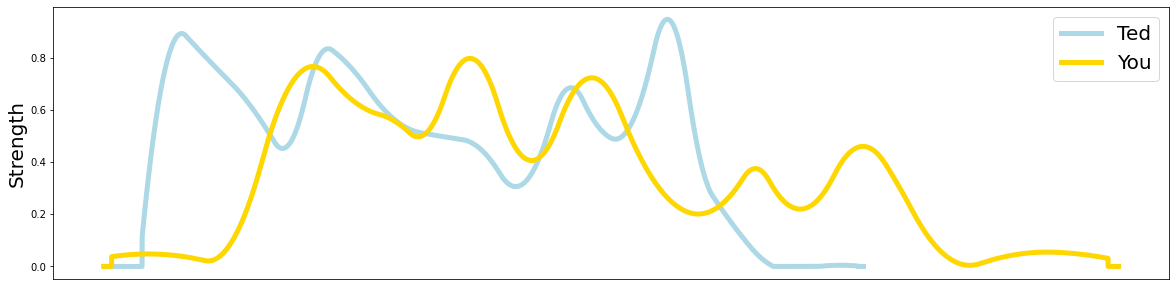

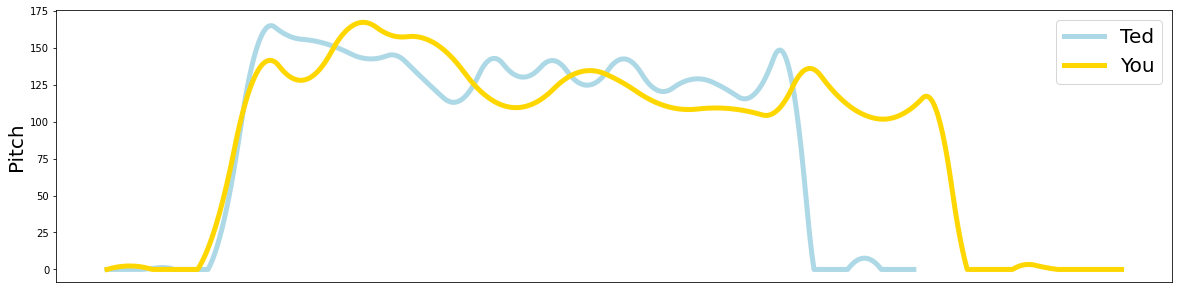

In [50]:
eval(ted_audio_path, user_audio_path, png_save_path)